In [1]:
import os, shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from PIL import ImageFont
from PIL import ImageDraw, ImageOps
import string

## Generate input images with watermarks

In [2]:
# list printable characters
printable = list(string.printable)[0:84]

In [3]:
def gen_watermark(img_str, train=1):
    # open the image as jpegs
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/RAWS/{}".format(img_str))
    
    # generate random font sizes 30 - 100
    np.random.seed()
    font_size = np.random.randint(low = 30, high = 100)
    
    # create the watermark font
    font = ImageFont.truetype("/home/tensorflow/Downloads/VOCdevkit/abel-regular.ttf", font_size)
    
    # generate image to hold the watermark
    img_temp = Image.new('L', (350,350))
    
    # create the watermark text
    np.random.seed()
    text_str = np.random.choice(printable, np.random.randint(low=5, high=10))
    text_str = "".join(text_str)
    
    # draw on the temporary image
    draw_temp = ImageDraw.Draw(img_temp)
    
    # generate random opacity level
    np.random.seed()
    opacity = np.random.randint(low=90, high=120)
    
    # insert text onto the temporary image
    draw_temp.text((0,0), text_str, font=font, fill=opacity)
    
    # generate random rotation angle
    np.random.seed()
    rot_int = np.random.randint(low=0, high=40)
    
    # rotate the text
    rotated_text = img_temp.rotate(rot_int, expand=1)
    
    # default text color = white
    col_1 = (255,255,255)
    col_2 = (255,255,255)
    
    # generate random location to put the text
    np.random.seed()
    rand_loc = tuple(np.random.randint(low=10,high=100,size=(2,)))
    
    # merge the temporary image
    img.paste(ImageOps.colorize(rotated_text, col_1, col_2), rand_loc, rotated_text)
    
    # save the watermarked image
    img.save("/home/tensorflow/Downloads/VOCdevkit/WATS/{}".format(img_str))

In [4]:
# Prepare the directory

wat_path = "/home/tensorflow/Downloads/VOCdevkit/WATS"
    
if not os.path.exists(wat_path):
    os.mkdir(wat_path)
else:
    shutil.rmtree(wat_path)

In [5]:
# Or else it will crash
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
# Generate watermarked images

img_list = os.listdir("/home/tensorflow/Downloads/VOCdevkit/RAWS")

for _, img in enumerate(img_list):
    gen_watermark(img)

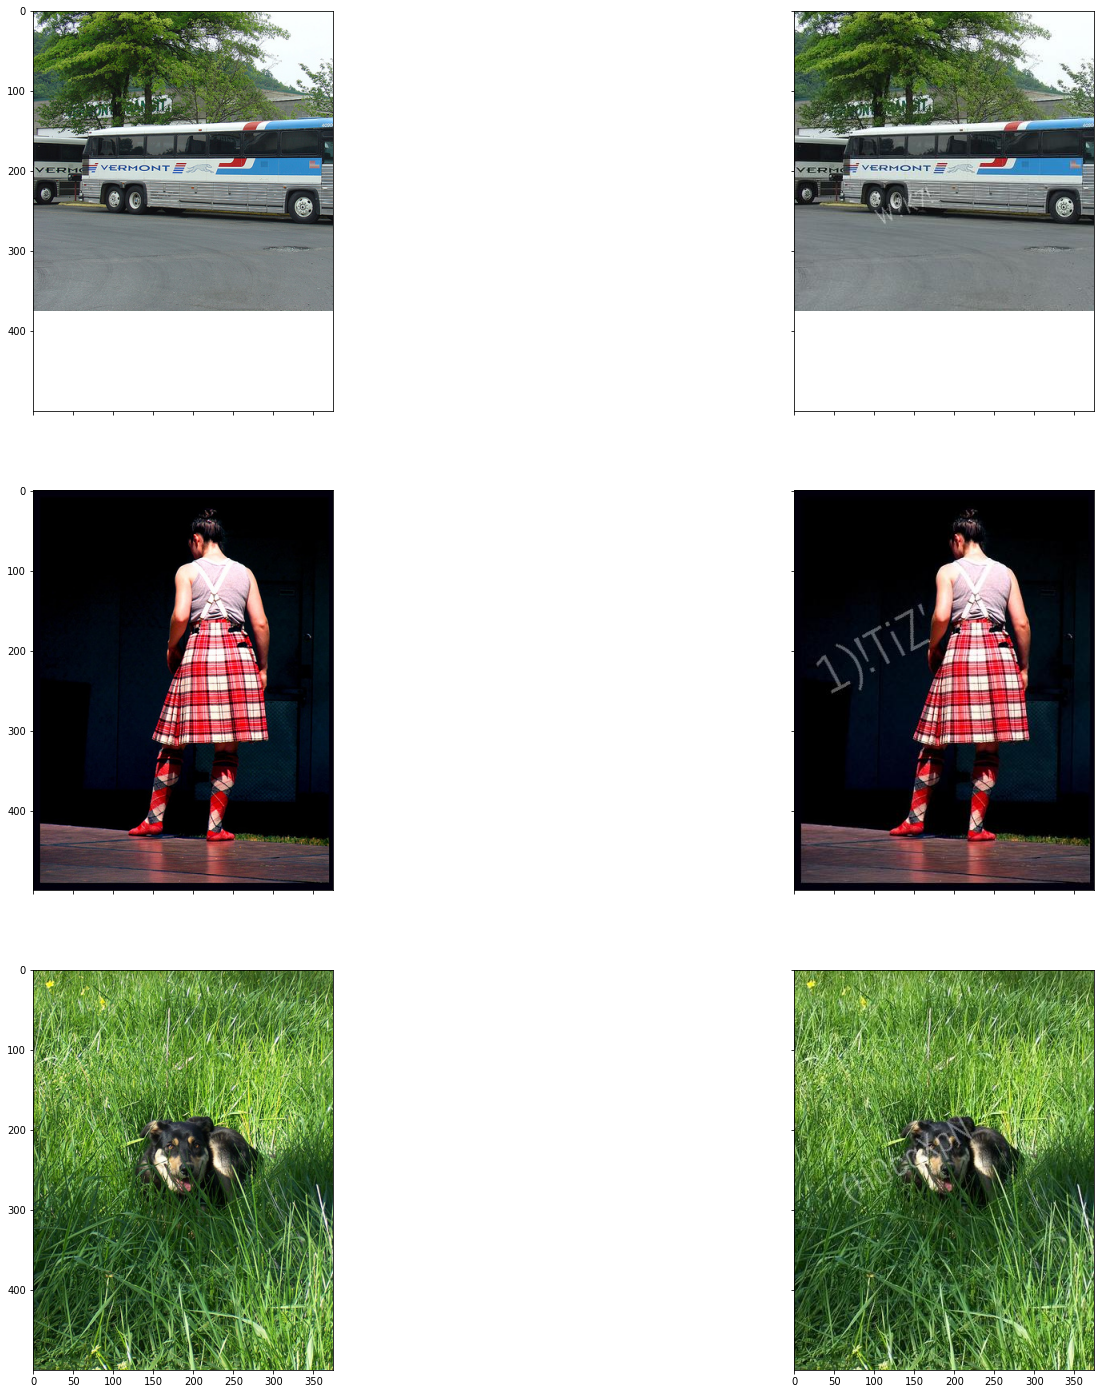

In [7]:
# Show some images

raw_str = "/home/tensorflow/Downloads/VOCdevkit/RAWS/"
wat_str = "/home/tensorflow/Downloads/VOCdevkit/WATS/"

dir_raw = os.listdir("/home/tensorflow/Downloads/VOCdevkit/RAWS")
dir_wat = os.listdir("/home/tensorflow/Downloads/VOCdevkit/WATS")

f, axs = plt.subplots(3,2, figsize=(25, 25), sharey=True, sharex = True)
axs = axs.ravel()

img_raw = Image.open(raw_str + dir_raw[4])
img_wat = Image.open(wat_str + dir_wat[4])
axs[0].imshow(img_raw)
axs[1].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[5])
img_wat = Image.open(wat_str + dir_wat[5])
axs[2].imshow(img_raw)
axs[3].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[10])
img_wat = Image.open(wat_str + dir_wat[10])
axs[4].imshow(img_raw)
axs[5].imshow(img_wat)

plt.show()

## Network Code

### Transform inputs and labels

In [8]:
train_wat_path = "/home/tensorflow/Downloads/VOCdevkit/train/wat_imgs"
train_raw_path = "/home/tensorflow/Downloads/VOCdevkit/train/raw_imgs"
val_wat_path = "/home/tensorflow/Downloads/VOCdevkit/val/wat_imgs"
val_raw_path = "/home/tensorflow/Downloads/VOCdevkit/val/raw_imgs"

In [9]:
# Seperate training and validation inputs/labels
    
if not os.path.exists(train_raw_path):
    os.mkdir(train_raw_path)
    
if not os.path.exists(val_raw_path):
    os.mkdir(val_raw_path)
    
if not os.path.exists(train_wat_path):
    os.mkdir(train_wat_path)
else:
    shutil.rmtree(train_wat_path)
    
if not os.path.exists(val_wat_path):
    os.mkdir(val_wat_path)
else:
    shutil.rmtree(val_wat_path)

In [10]:
# Copy raw images over

raw_list = os.listdir("/home/tensorflow/Downloads/VOCdevkit/RAWS")

for ind, img_str in enumerate(raw_list):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/RAWS/{}".format(img_str))
    if ind < 4900:
        img.save("/home/tensorflow/Downloads/VOCdevkit/train/raw_imgs/{}".format(img_str))
    else:
        img.save("/home/tensorflow/Downloads/VOCdevkit/val/raw_imgs/{}".format(img_str))

In [11]:
# Copy watermarked images over

wat_list = os.listdir("/home/tensorflow/Downloads/VOCdevkit/WATS")

for ind, img_str in enumerate(wat_list):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/WATS/{}".format(img_str))
    if ind < 4900:
        img.save("/home/tensorflow/Downloads/VOCdevkit/train/wat_imgs/{}".format(img_str))
    else:
        img.save("/home/tensorflow/Downloads/VOCdevkit/val/wat_imgs/{}".format(img_str))

In [12]:
# Standardize and normalize

x_train = np.ndarray(shape=(4900, 128, 128, 3),
                     dtype=np.float32)
y_train = np.ndarray(shape=(4900, 128, 128, 3),
                     dtype=np.float32)
x_val = np.ndarray(shape=(196, 128, 128, 3),
                     dtype=np.float32)
y_val = np.ndarray(shape=(196, 128, 128, 3),
                     dtype=np.float32)

i = 0
for file in os.listdir(train_wat_path):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/train/wat_imgs/{}".format(file))
    img = np.array(img.resize((128,128))) / 255
    img = img.astype('float32')
    x_train[i] = img
    i += 1
    
i = 0
for file in os.listdir(train_raw_path):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/train/raw_imgs/{}".format(file))
    img = np.array(img.resize((128,128))) / 255
    img = img.astype('float32')
    y_train[i] = img
    i += 1
    
i = 0
for file in os.listdir(val_wat_path):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/val/wat_imgs/{}".format(file))
    img = np.array(img.resize((128,128))) / 255
    img = img.astype('float32')
    x_val[i] = img
    i += 1
    
i = 0
for file in os.listdir(val_raw_path):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/val/raw_imgs/{}".format(file))
    img = np.array(img.resize((128,128))) / 255
    img = img.astype('float32')
    y_val[i] = img
    i += 1

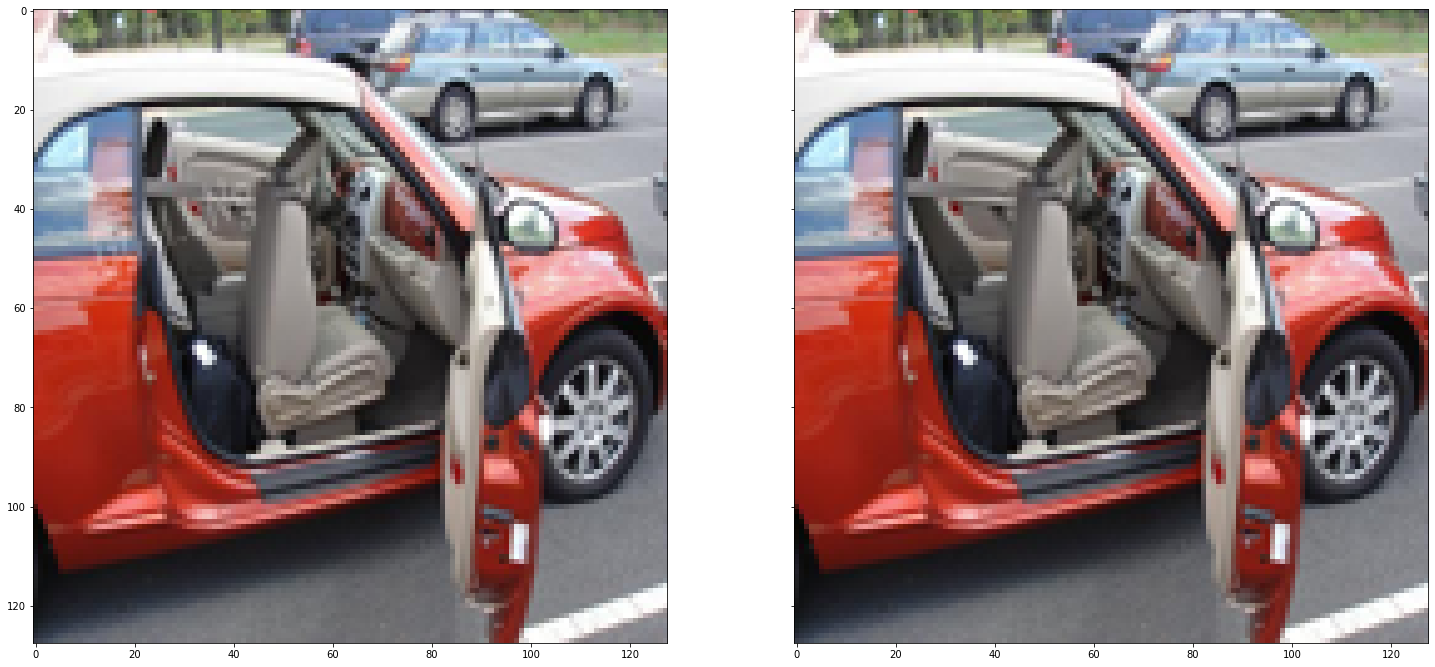

In [13]:
# See images after transforming

fig, axs = plt.subplots(1, 2, figsize=(25, 25), sharey=True, sharex = True)

img_1 = x_train[0]
img_2 = y_train[0]

axs[0].imshow(img_1)
axs[1].imshow(img_2)

### Create model

In [14]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
    pool1 = Dropout(0.25)(pool1)
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    pool2 = Dropout(0.5)(pool2)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
    pool3 = Dropout(0.5)(pool3)
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)
    pool4 = Dropout(0.5)(pool4)
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    up6 = Dropout(0.5)(up6)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    up7 = Dropout(0.5)(up7)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    up8= Dropout(0.5)(up8)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    up9= Dropout(0.25)(up9)
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [15]:
model = inpaintingModel().prepare_model()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training

In [16]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

history = model.fit(x_train, y_train,
                   validation_data=(x_val, y_val),
                   epochs=30,
                   batch_size=32,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/30
154/154 [==============================] - 132s 764ms/step - loss: 0.5882 - accuracy: 0.5445 - val_loss: 0.5275 - val_accuracy: 0.8164

Epoch 00001: val_loss improved from inf to 0.52747, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
Epoch 2/30
154/154 [==============================] - 113s 735ms/step - loss: 0.5266 - accuracy: 0.7876 - val_loss: 0.5246 - val_accuracy: 0.8419

Epoch 00002: val_loss improved from 0.52747 to 0.52456, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
Epoch 3/30
154/154 [==============================] - 114s 739ms/step - loss: 0.5215 - accuracy: 0.8043 - val_loss: 0.5226 - val_accuracy: 0.8693

Epoch 00003: val_loss improved from 0.52456 to 0.52256, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
Epoch 4/30
154/154 [==============================] - 114s 738ms/step - loss: 0.5216 - accuracy: 0.8182 - val_loss: 0.5210 - val_accuracy

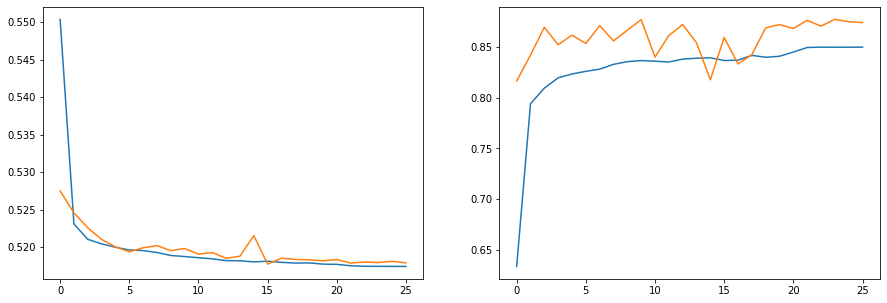

In [17]:
# Visualize the training process

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")

## Test

In [ ]:
model = load_model("./keras.model")

In [18]:
# Generate watermark (again)

def watermark(img_str):
    img = Image.open("/home/tensorflow/Downloads/VOCdevkit/TEST/RAW/{}".format(img_str))
    img = img.resize((512,round(img.size[1]*512/img.size[0])))
    
    np.random.seed()
    font_size = np.random.randint(low = 30, high = 100)
    
    font = ImageFont.truetype("/home/tensorflow/Downloads/VOCdevkit/abel-regular.ttf", font_size)
    
    img_temp = Image.new('L', (350,350))
    
    np.random.seed()
    text_str = np.random.choice(printable, np.random.randint(low=5, high=10))
    text_str = "".join(text_str)
    
    draw_temp = ImageDraw.Draw(img_temp)
    
    np.random.seed()
    opacity = np.random.randint(low=90, high=120)
    
    # insert text onto the temporary image
    draw_temp.text((0,0), text_str, font=font, fill=opacity)
    
    np.random.seed()
    rot_int = np.random.randint(low=0, high=30)
    
    rotated_text = img_temp.rotate(rot_int, expand=1)
    
    col_1 = (255,255,255)
    col_2 = (255,255,255)
    
    np.random.seed()
    rand_loc = tuple(np.random.randint(low=10,high=100,size=(2,)))
    
    img.paste(ImageOps.colorize(rotated_text, col_1, col_2), rand_loc, rotated_text)
    
    img.save("/home/tensorflow/Downloads/VOCdevkit/TEST/WAT/{}".format(img_str))
    return img

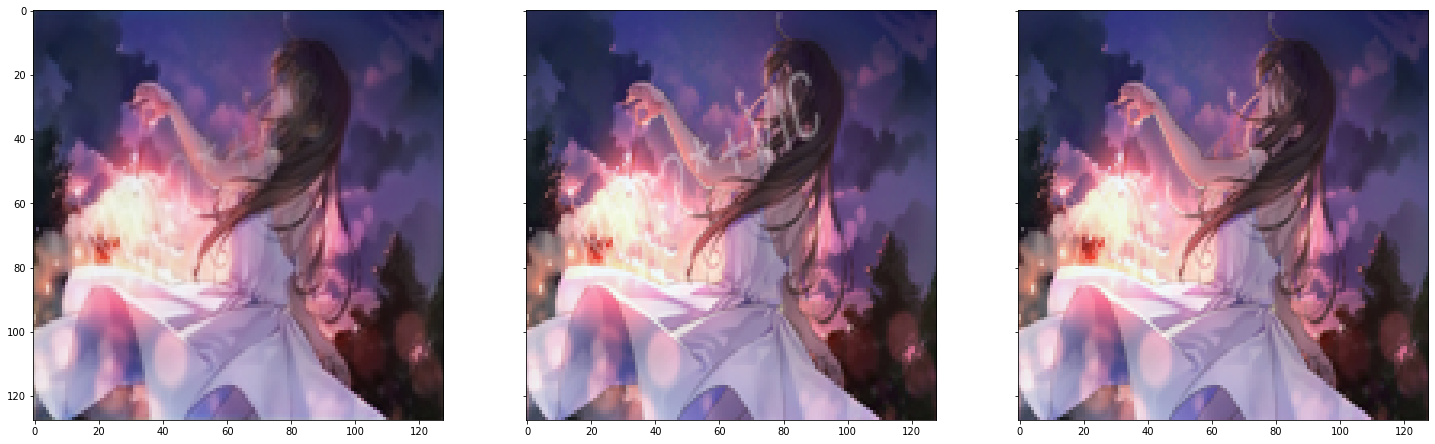

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(25, 25), sharey=True, sharex = True)

# The watermarked image
wat_img = watermark("1.jpg")
wat_img = np.array(wat_img.resize((128,128))) / 255
wat_img = wat_img.astype('float32')

# The predicted image
rec_img = model.predict(wat_img.reshape((1,)+wat_img.shape))
rec_img = rec_img.reshape(rec_img.shape[1:])

# The original image (reshaped)
tr_img = Image.open("/home/tensorflow/Downloads/VOCdevkit/TEST/RAW/1.jpg")
tr_img = np.array(tr_img.resize((128,128))) / 255
tr_img = tr_img.astype('float32')

axs[0].imshow(rec_img)
axs[1].imshow(wat_img)
axs[2].imshow(tr_img)